In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [3]:
df = pd.read_excel("premiums.xlsx")
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [4]:
df.shape

(50000, 13)

In [5]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount'],
      dtype='object')

In [6]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [7]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [8]:
df.dropna(inplace=True)

## Handle NA Values

In [9]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [10]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [11]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [12]:
df[df.number_of_dependants < 0].shape
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-3, -1])

In [13]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [14]:
numeric_columns = df.select_dtypes(["float64", "int64"]).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

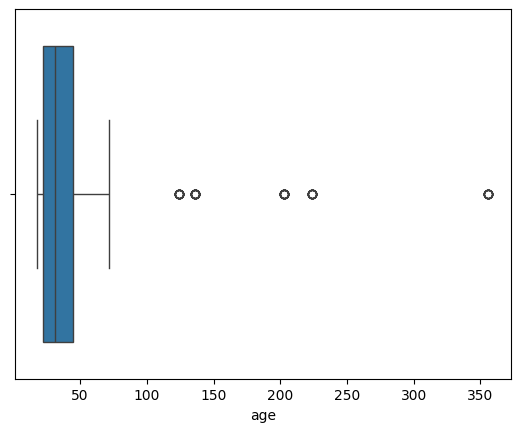

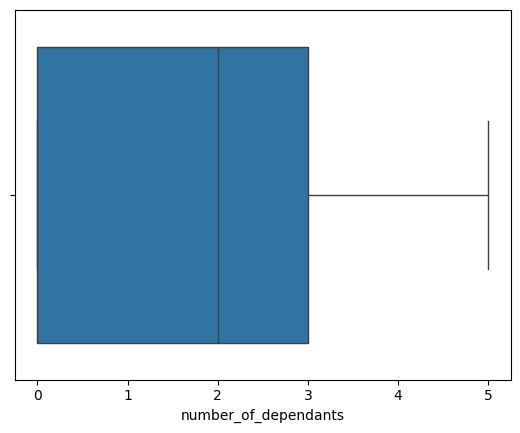

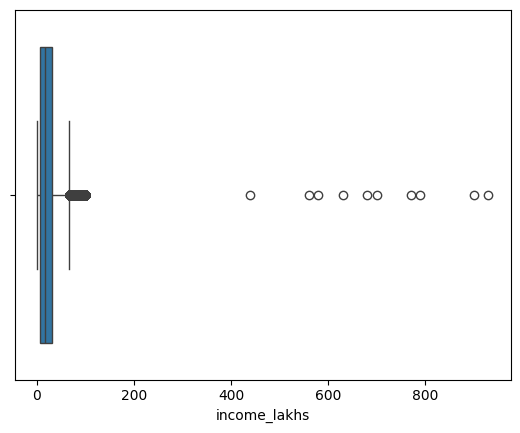

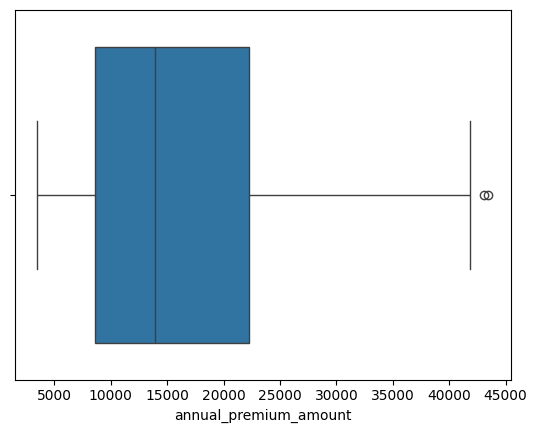

In [15]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [16]:
df[df.age > 100]["age"].unique()

array([224, 124, 136, 203, 356])

In [17]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

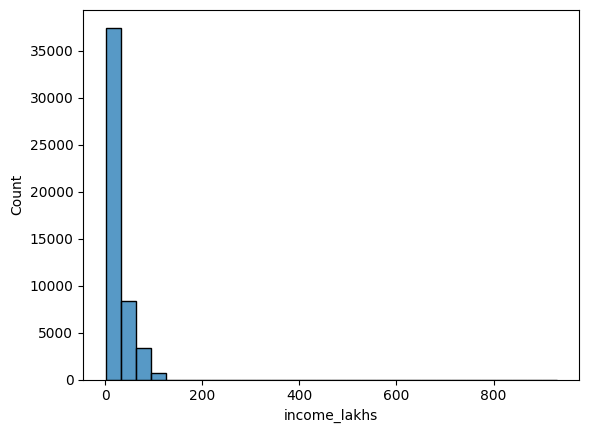

In [18]:
sns.histplot(df1.income_lakhs, bins=30)

In [19]:
df1.income_lakhs.quantile([0.25, 0.75])

0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [20]:
def get_iqr_bounds(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [21]:
get_iqr_bounds(df1.income_lakhs)

(np.float64(-29.0), np.float64(67.0))

In [22]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [23]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


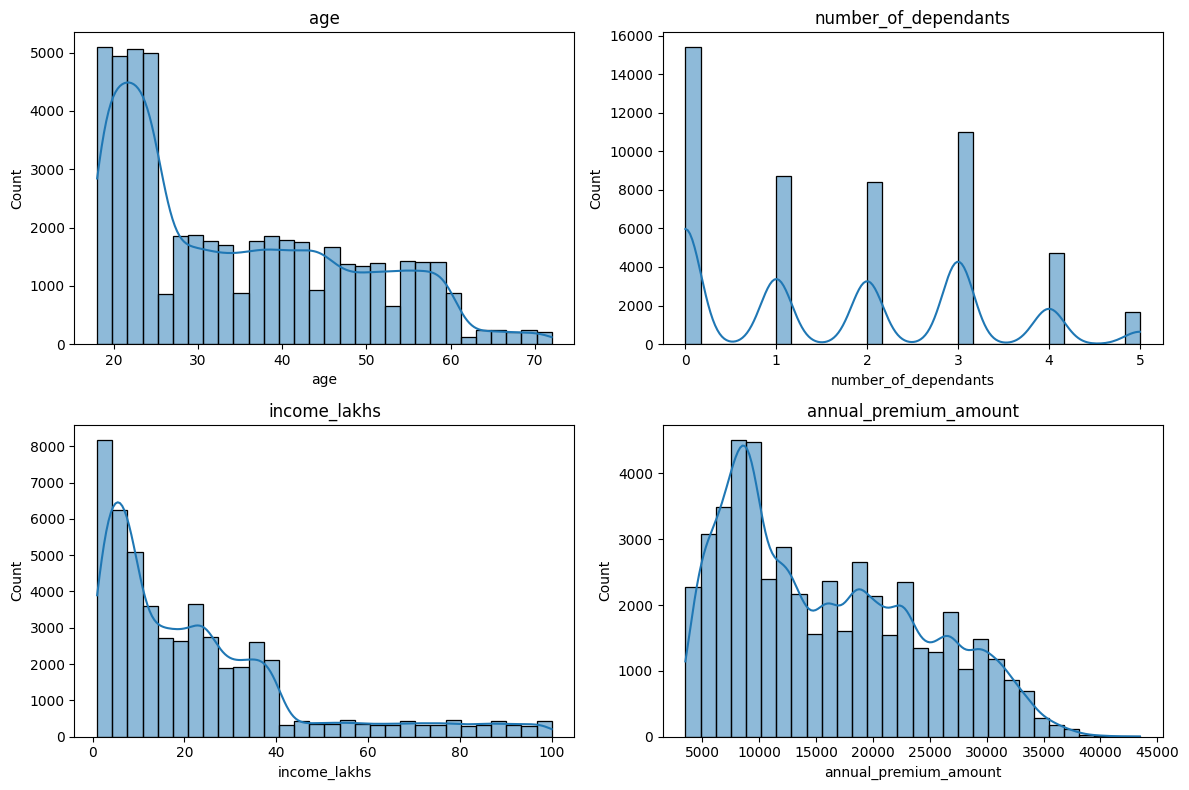

In [26]:
# Define the number of columns per row
num_cols = 2
num_plots = len(numeric_columns)
num_rows = (
    num_plots + num_cols - 1
) // num_cols  # To calculate the required number of rows

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(12, num_rows * 4)
)  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array

for i, col in enumerate(numeric_columns):
    sns.histplot(
        x=df2[col], kde=True, bins=30, ax=axes[i]
    )  # Plot in the respective subplot
    axes[i].set_title(col)

# Remove any empty subplots if num_plots is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

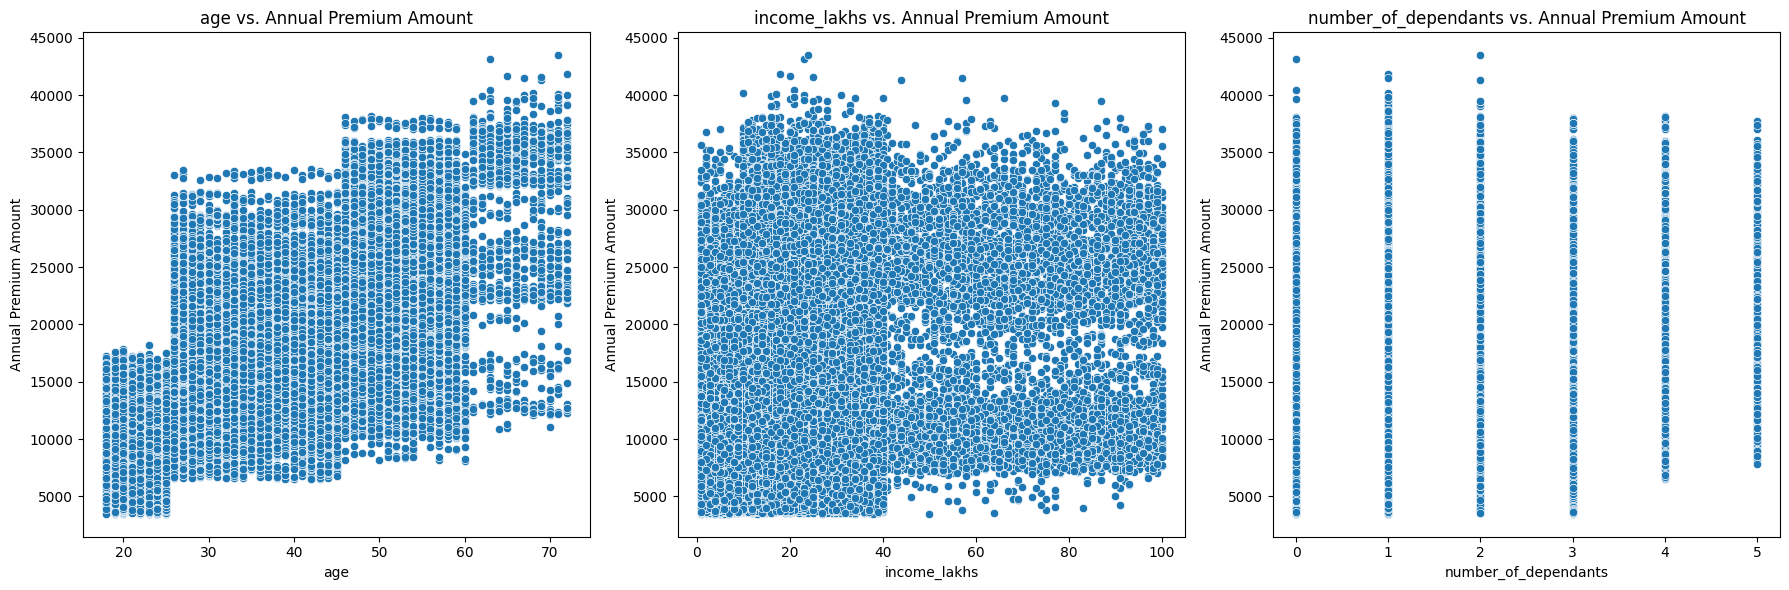

In [30]:
numeric_features = ["age", "income_lakhs", "number_of_dependants"]

fig, axes = plt.subplots(
    1, len(numeric_features), figsize=(18, 6)
)  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df2[column], y=df2["annual_premium_amount"], ax=ax)
    ax.set_title(f"{column} vs. Annual Premium Amount")
    ax.set_xlabel(column)
    ax.set_ylabel("Annual Premium Amount")

plt.tight_layout()  # Adjust layout
plt.show()

In [31]:
categorical_cols = [
    "gender",
    "region",
    "marital_status",
    "bmi_category",
    "smoking_status",
    "employment_status",
    "income_level",
    "medical_history",
    "insurance_plan",
]
for col in categorical_cols:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [32]:
df2["smoking_status"].replace(
    {
        "Not Smoking": "No Smoking",
        "Does Not Smoke": "No Smoking",
        "Smoking=0": "No Smoking",
    },
    inplace=True,
)

df2["smoking_status"].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [34]:
pct_count = df2["gender"].value_counts(normalize=True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

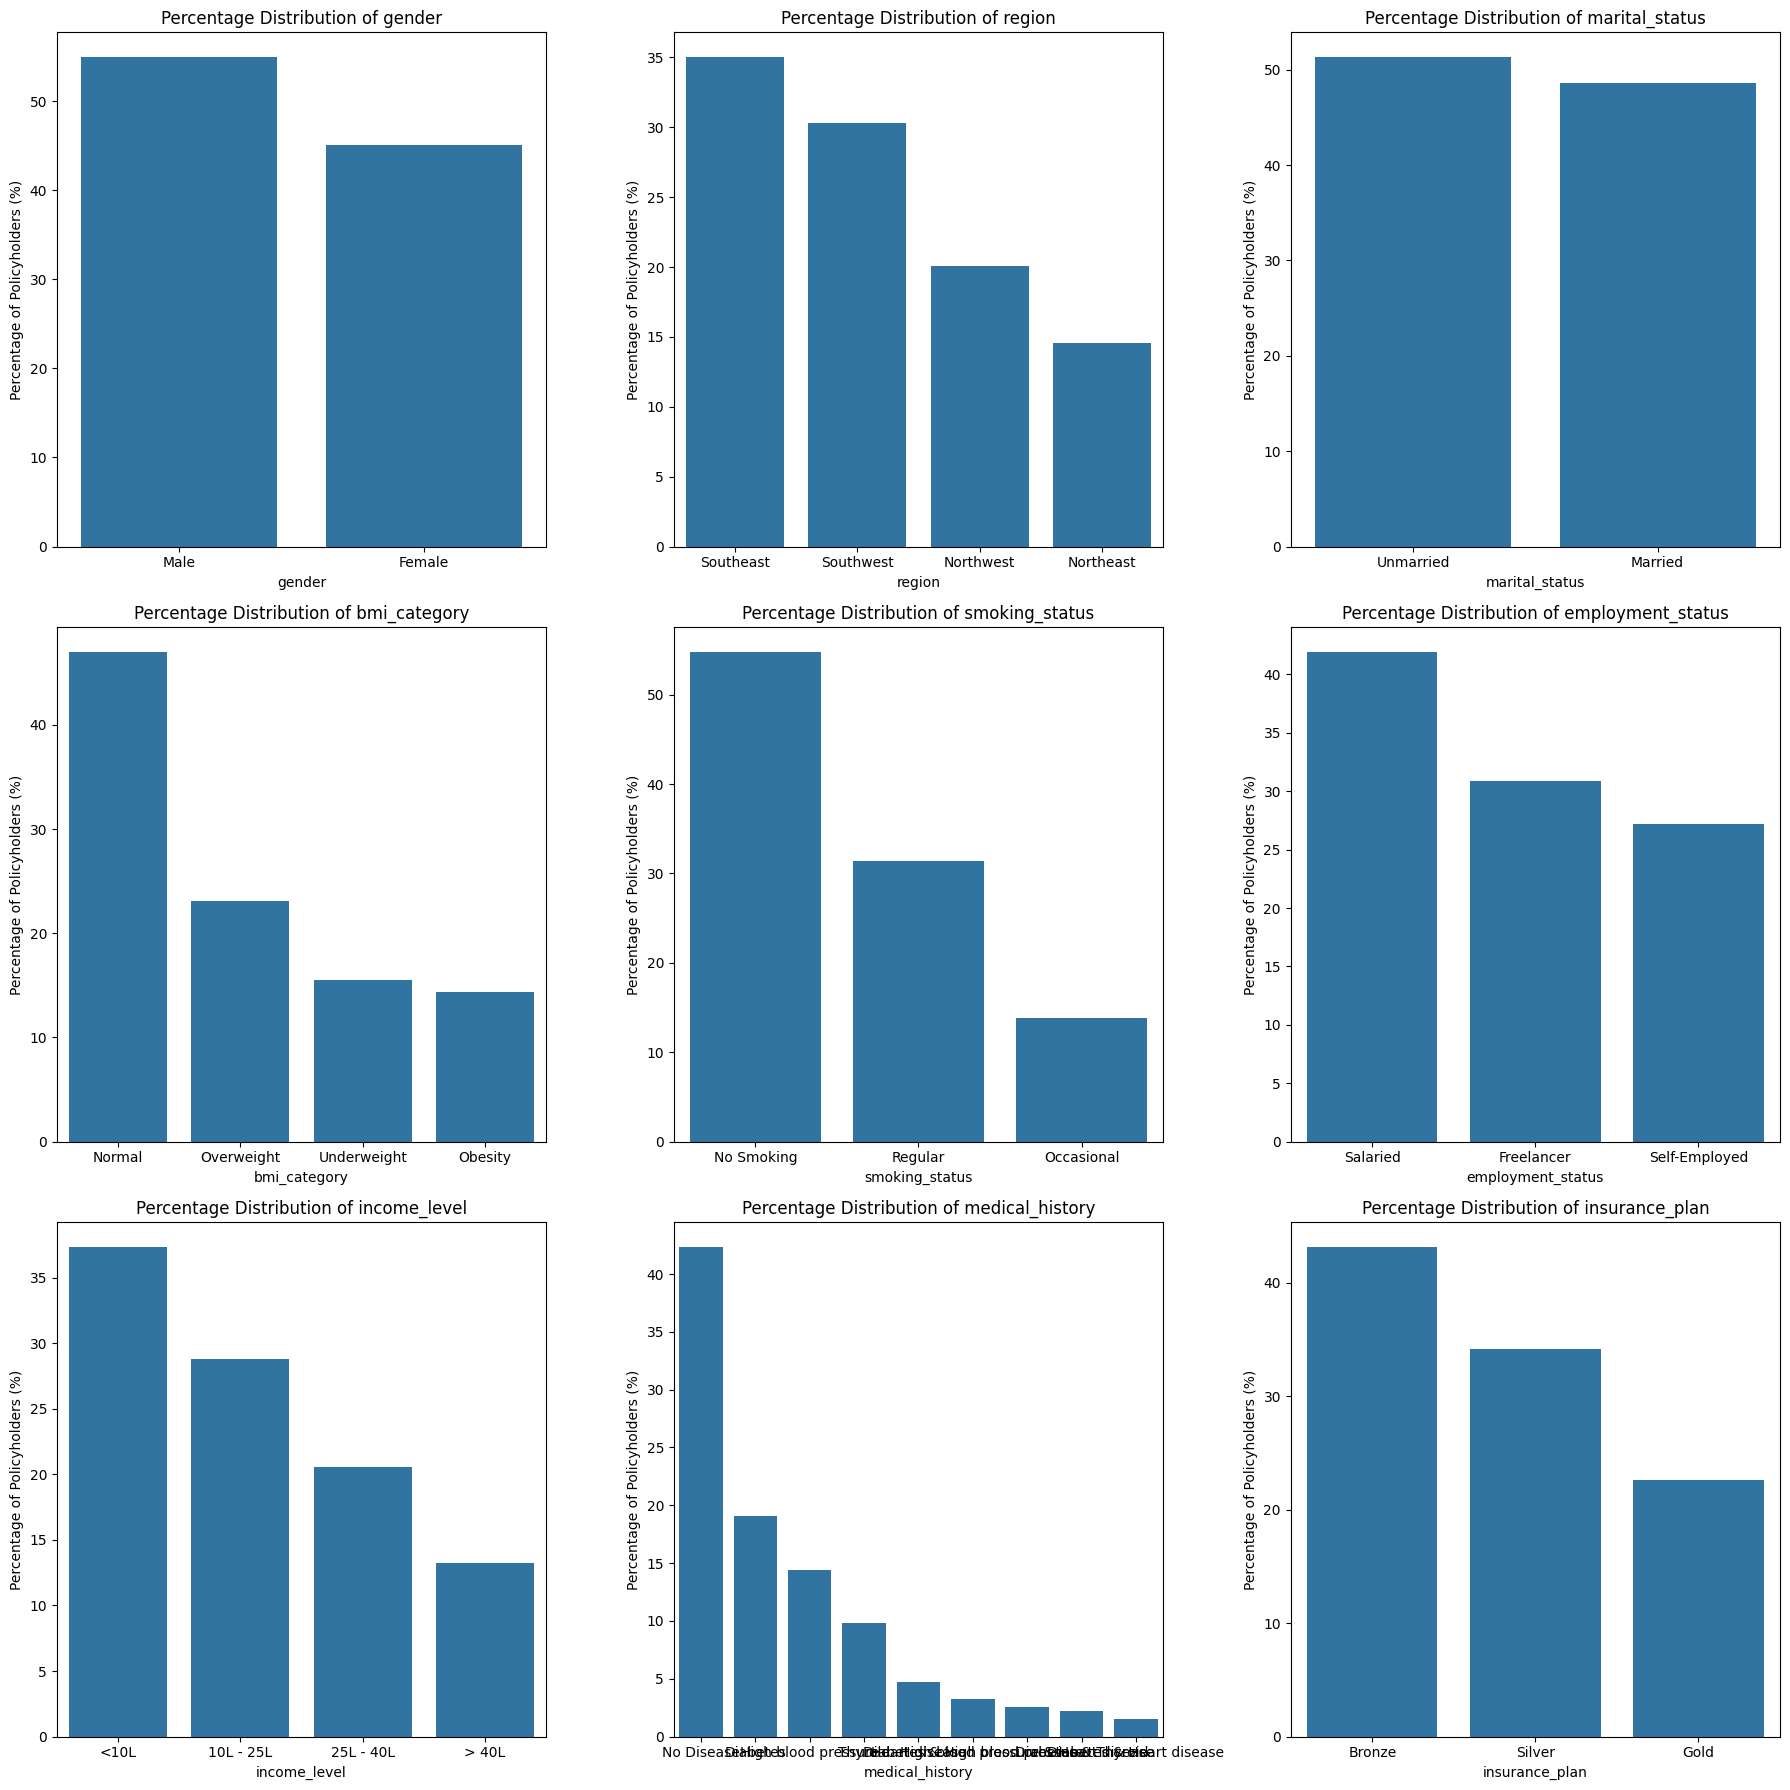

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = (
        df2[column].value_counts(normalize=True) * 100
    )  # normalize=True gives the relative frequencies

    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Percentage Distribution of {column}")
    ax.set_ylabel("Percentage of Policyholders (%)")
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


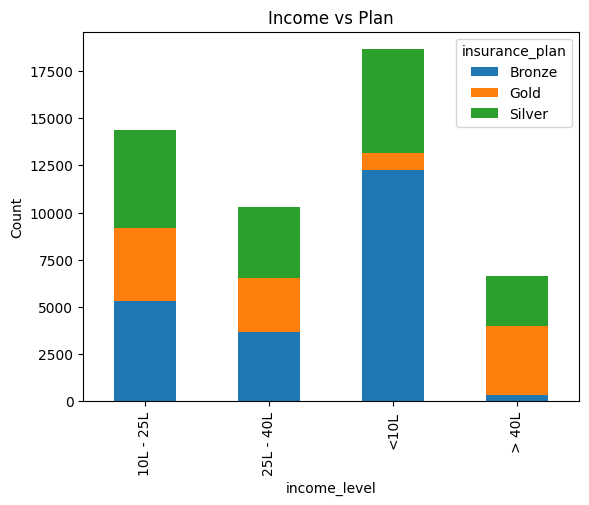

In [37]:
# Cross-tabulation of gender and smoking status
crosstab = pd.crosstab(df2["income_level"], df2["insurance_plan"])
print(crosstab)

# Plotting the crosstab
crosstab.plot(kind="bar", stacked=True)
plt.title("Income vs Plan")
plt.ylabel("Count")
plt.show()

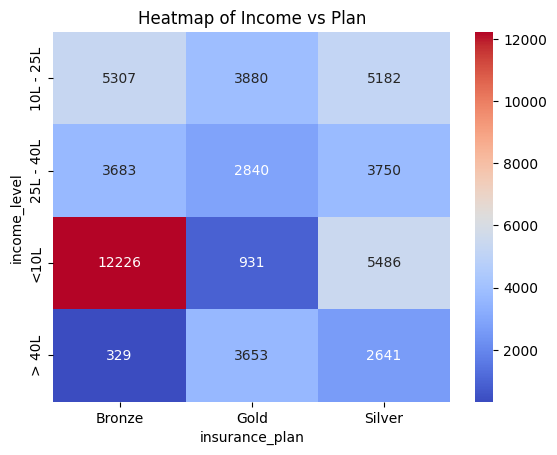

In [38]:
sns.heatmap(crosstab, annot=True, cmap="coolwarm", fmt="d")
plt.title("Heatmap of Income vs Plan")
plt.show()